Here is an example of loading up the baseline simualtion and returning information about the visits that overlap a single point in the sky.

Installation instructions for rubin_sim can be found in the README at: https://github.com/lsst/rubin_sim

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp

import rubin_sim.maf as maf
import rubin_scheduler.utils as rsUtils
from rubin_scheduler.data import get_baseline

In [2]:
# Grab the current baseline file. Should have been downloaded with rubin_sim. 
# Can grab lots of different sims from: http://astro-lsst-01.astro.washington.edu:8081/
baseline_file = '../baseline/baseline_v3.4_10yrs.db'#get_baseline()
name = os.path.basename(baseline_file).replace('.db','')
out_dir = 'temp'
results_db = maf.db.ResultsDb(out_dir=out_dir)

In [3]:
bundle_list = []
# The point on the sky we would like to get visits for
ra = [0.]
dec = [-20]


# Say we just want to pass data through, not compute anything. Documentation on 
# columns at:  https://rubin-sim.lsst.io/rs_scheduler/output_schema.html
metric = maf.metrics.PassMetric(cols=['filter', 'observationStartMJD', 'fiveSigmaDepth', 'visitExposureTime', 'night'])
# Select all the visits. Could be something like "filter='r'", "night < 365", etc
sql = ''
slicer = maf.slicers.UserPointsSlicer(ra=ra, dec=dec)
bundle_list.append(maf.MetricBundle(metric, slicer, sql, run_name=name))

In [4]:
bd = maf.metricBundles.make_bundles_dict_from_list(bundle_list)
bg = maf.metricBundles.MetricBundleGroup(bd, baseline_file, out_dir=out_dir, results_db=results_db)
bg.run_all()


In [5]:
# Our bundleList now has values. The trailing [0] is to get the first result. If we specified more
# ra,dec point, those results would be in the later indices.
bundle_list[0].metric_values[0][0:10]

rec.array([(30., 274.0693722 , 62490.0511035 , 1694, -21.33458836, 22.992207  , 358.93954395, 'z'),
           (30., 274.0693722 , 62490.03758448, 1694, -21.33458836, 23.12123292, 358.93954395, 'i'),
           (30., 199.16815434, 62041.2586319 , 1245, -21.3485068 , 22.06576414, 358.68897327, 'y'),
           (30., 199.16815434, 62041.23622066, 1245, -21.3485068 , 22.03578977, 358.68897327, 'y'),
           (30., 293.49445974, 61315.25762988,  519, -21.48174169, 24.04991005, 359.20581593, 'r'),
           (30., 163.76142718, 63833.37202944, 3037, -21.62078633, 22.57629896, 359.83723334, 'u'),
           (15., 283.82051691, 61436.03475048,  640, -21.34600388, 21.84101664, 359.04966878, 'i'),
           (30., 271.24843753, 63198.08663186, 2402, -21.65804678, 23.21211303, 359.28237851, 'i'),
           (30., 174.84934612, 62703.43427383, 1907, -21.32385054, 22.2762193 , 359.47852235, 'y'),
           (30., 185.88682281, 61403.03983784,  607, -21.38408725, 23.32094308, 359.40065933, 'i')],

Text(0.5, 1.0, 'baseline_v3.4_10yrs\nObservations at ra=0.000, dec=-20.000')

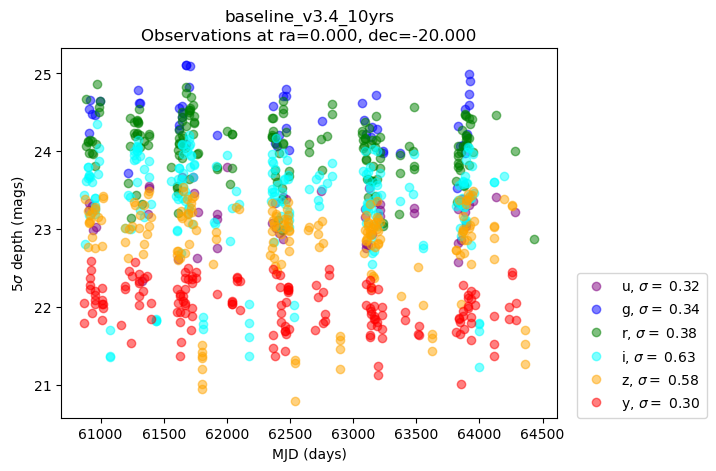

In [6]:
# As a bit of foreshadowing for how the rest of MAF works, we'll call the visits overlapping a
# single point in the sky "dataSlice". 
data_slice = bundle_list[0].metric_values[0]

# Let's plot up what the 5-sigma depth looks like
plt.figure()
# Give each filter it's own color
f2c = {'u': 'purple', 'g': 'blue', 'r': 'green',
       'i': 'cyan', 'z': 'orange', 'y': 'red'}
for fn in f2c:
    in_filt = np.where(data_slice['filter'] == fn)[0]
    plt.plot(data_slice['observationStartMJD'][in_filt],
             data_slice['fiveSigmaDepth'][in_filt], 'o',
             color=f2c[fn],
             label=fn+r', $\sigma=$ %.2f' % (np.std(data_slice['fiveSigmaDepth'][in_filt])),
             alpha=0.5)
plt.xlabel('MJD (days)')
plt.ylabel(r'5$\sigma$ depth (mags)')
plt.legend(loc=(1.04,0))
plt.title('%s\nObservations at ra=%.3f, dec=%.3f' % (name, ra[0],dec[0]))

Text(0.5, 1.0, 'baseline_v3.4_10yrs\nObservations at ra=0.000, dec=-20.000')

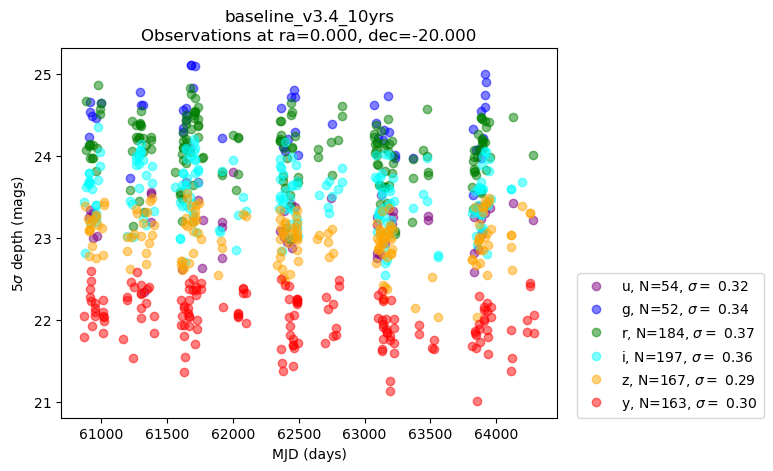

In [7]:
# Note there are some odd low-depth outliers. Those are probably the 1x15s
# twilight time exposures. let's try filtering those out

data_slice = bundle_list[0].metric_values[0]

# crop off short exposure times
data_slice = data_slice[np.where(data_slice["visitExposureTime"] > 25.)]

# Let's plot up what the 5-sigma depth looks like
plt.figure()
# Give each filter it's own color
f2c = {'u': 'purple', 'g': 'blue', 'r': 'green',
       'i': 'cyan', 'z': 'orange', 'y': 'red'}
for fn in f2c:
    in_filt = np.where(data_slice['filter'] == fn)[0]
    plt.plot(data_slice['observationStartMJD'][in_filt],
             data_slice['fiveSigmaDepth'][in_filt], 'o',
             color=f2c[fn],
             label=fn+r', N=%i, $\sigma=$ %.2f' % (np.size(in_filt), np.std(data_slice['fiveSigmaDepth'][in_filt])),
             alpha=0.5)
plt.xlabel('MJD (days)')
plt.ylabel(r'5$\sigma$ depth (mags)')
plt.legend(loc=(1.04,0))
plt.title('%s\nObservations at ra=%.3f, dec=%.3f' % (name, ra[0],dec[0]))

Text(0.5, 0, 'Night gap')

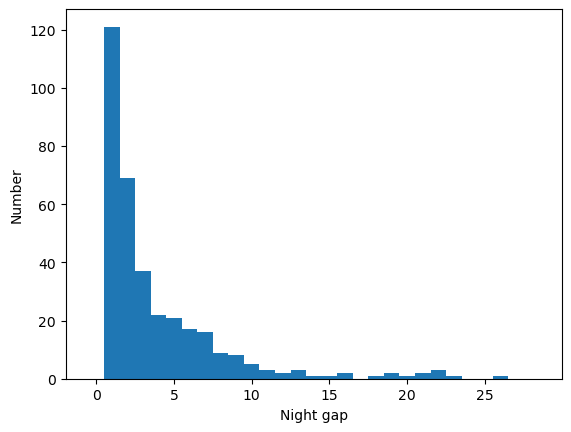

In [13]:
un = np.unique(data_slice["night"])
plt.hist(un[1:] - un[:-1], bins=np.arange(30)-0.5)
plt.ylabel("Number")
plt.xlabel("Night gap")

Text(0.5, 1.0, 'baseline_v3.4_10yrs\nObservations at ra=0.000, dec=-20.000')

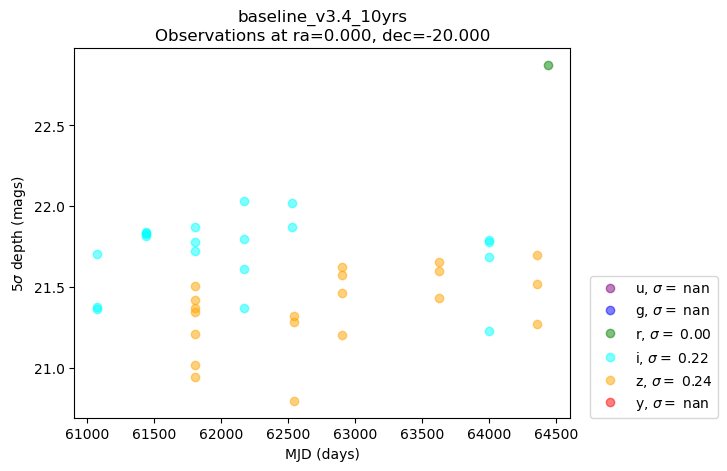

In [8]:
# and now looking only at short exposure times

data_slice = bundle_list[0].metric_values[0]

# Include only short exposures
data_slice = data_slice[np.where(data_slice["visitExposureTime"] < 25.)]

# Let's plot up what the 5-sigma depth looks like
plt.figure()
# Give each filter it's own color
f2c = {'u': 'purple', 'g': 'blue', 'r': 'green',
       'i': 'cyan', 'z': 'orange', 'y': 'red'}
for fn in f2c:
    in_filt = np.where(data_slice['filter'] == fn)[0]
    plt.plot(data_slice['observationStartMJD'][in_filt],
             data_slice['fiveSigmaDepth'][in_filt], 'o',
             color=f2c[fn],
             label=fn+r', $\sigma=$ %.2f' % (np.std(data_slice['fiveSigmaDepth'][in_filt])),
             alpha=0.5)
plt.xlabel('MJD (days)')
plt.ylabel(r'5$\sigma$ depth (mags)')
plt.legend(loc=(1.04,0))
plt.title('%s\nObservations at ra=%.3f, dec=%.3f' % (name, ra[0],dec[0]))

Let's try out doing it on a DDF location

In [24]:
bundle_list = []
# The point on the sky we would like to get visits for
ra = [9.450]
dec = [-44.0]


# Say we just want to pass data through, not compute anything. Documentation on 
# columns at:  https://rubin-sim.lsst.io/rs_scheduler/output_schema.html
metric = maf.metrics.PassMetric(cols=['filter', 'observationStartMJD', 'fiveSigmaDepth', 'visitExposureTime', 'night'])
# Select all the visits. Could be something like "filter='r'", "night < 365", etc
sql = 'note like "DD%"'
slicer = maf.slicers.UserPointsSlicer(ra=ra, dec=dec)
bundle_list.append(maf.MetricBundle(metric, slicer, sql, run_name=name))

bd = maf.metricBundles.make_bundles_dict_from_list(bundle_list)
bg = maf.metricBundles.MetricBundleGroup(bd, baseline_file, out_dir=out_dir, results_db=results_db)
bg.run_all()



Text(0.5, 1.0, 'baseline_v3.4_10yrs\nObservations at ra=9.450, dec=-44.000')

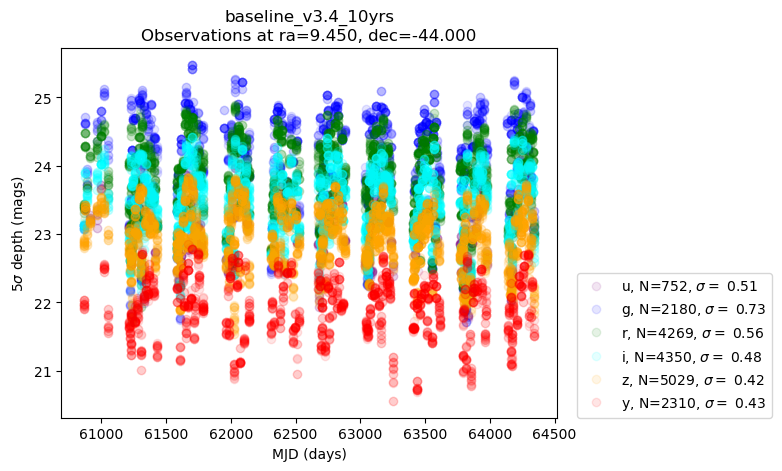

In [25]:
data_slice = bundle_list[0].metric_values[0]

# crop off short exposure times
data_slice = data_slice[np.where(data_slice["visitExposureTime"] > 25.)]

# Let's plot up what the 5-sigma depth looks like
plt.figure()
# Give each filter it's own color
f2c = {'u': 'purple', 'g': 'blue', 'r': 'green',
       'i': 'cyan', 'z': 'orange', 'y': 'red'}
for fn in f2c:
    in_filt = np.where(data_slice['filter'] == fn)[0]
    plt.plot(data_slice['observationStartMJD'][in_filt],
             data_slice['fiveSigmaDepth'][in_filt], 'o',
             color=f2c[fn],
             label=fn+r', N=%i, $\sigma=$ %.2f' % (np.size(in_filt), np.std(data_slice['fiveSigmaDepth'][in_filt])),
             alpha=0.1)
plt.xlabel('MJD (days)')
plt.ylabel(r'5$\sigma$ depth (mags)')
plt.legend(loc=(1.04,0))
plt.title('%s\nObservations at ra=%.3f, dec=%.3f' % (name, ra[0],dec[0]))

Text(0.5, 1.0, 'ELAISS1, DDF only')

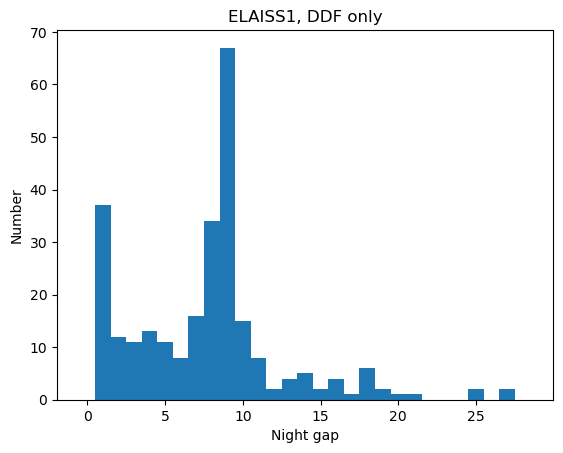

In [27]:
un = np.unique(data_slice["night"])
plt.hist(un[1:] - un[:-1], bins=np.arange(30)-0.5)
plt.ylabel("Number")
plt.xlabel("Night gap")
plt.title("ELAISS1, DDF only")

In [28]:
# OK, if I only look at DDF, then there's a strong peak at 7-8 days. If I include all observations,
# then the peak is at 1 night. 

In [29]:
bundle_list = []
# The point on the sky we would like to get visits for
ra = [9.450]
dec = [-44.0]


# Say we just want to pass data through, not compute anything. Documentation on 
# columns at:  https://rubin-sim.lsst.io/rs_scheduler/output_schema.html
metric = maf.metrics.PassMetric(cols=['filter', 'observationStartMJD', 'fiveSigmaDepth', 'visitExposureTime', 'night'])
# Select all the visits. Could be something like "filter='r'", "night < 365", etc
sql = ''
slicer = maf.slicers.UserPointsSlicer(ra=ra, dec=dec)
bundle_list.append(maf.MetricBundle(metric, slicer, sql, run_name=name))

bd = maf.metricBundles.make_bundles_dict_from_list(bundle_list)
bg = maf.metricBundles.MetricBundleGroup(bd, baseline_file, out_dir=out_dir, results_db=results_db)
bg.run_all()


Text(0.5, 1.0, 'baseline_v3.4_10yrs\nObservations at ra=9.450, dec=-44.000')

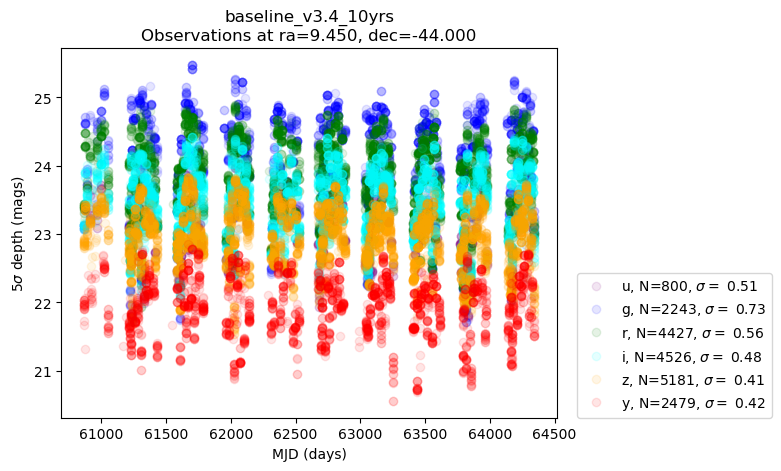

In [30]:
data_slice = bundle_list[0].metric_values[0]

# crop off short exposure times
data_slice = data_slice[np.where(data_slice["visitExposureTime"] > 25.)]

# Let's plot up what the 5-sigma depth looks like
plt.figure()
# Give each filter it's own color
f2c = {'u': 'purple', 'g': 'blue', 'r': 'green',
       'i': 'cyan', 'z': 'orange', 'y': 'red'}
for fn in f2c:
    in_filt = np.where(data_slice['filter'] == fn)[0]
    plt.plot(data_slice['observationStartMJD'][in_filt],
             data_slice['fiveSigmaDepth'][in_filt], 'o',
             color=f2c[fn],
             label=fn+r', N=%i, $\sigma=$ %.2f' % (np.size(in_filt), np.std(data_slice['fiveSigmaDepth'][in_filt])),
             alpha=0.1)
plt.xlabel('MJD (days)')
plt.ylabel(r'5$\sigma$ depth (mags)')
plt.legend(loc=(1.04,0))
plt.title('%s\nObservations at ra=%.3f, dec=%.3f' % (name, ra[0],dec[0]))

Text(0.5, 1.0, 'ELAISS1, all')

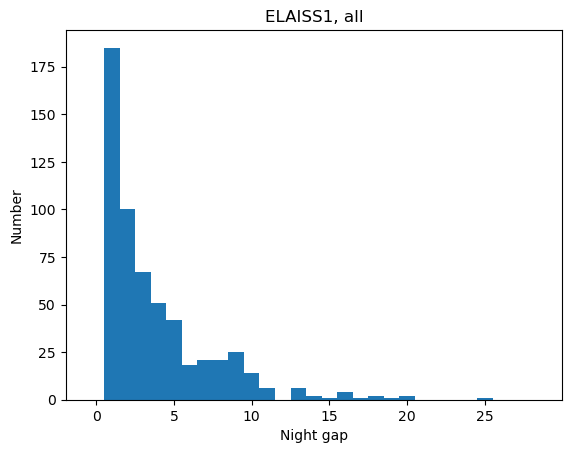

In [32]:
un = np.unique(data_slice["night"])
plt.hist(un[1:] - un[:-1], bins=np.arange(30)-0.5)
plt.ylabel("Number")
plt.xlabel("Night gap")
plt.title("ELAISS1, all")